In [1]:
import os
import pandas as pd
from keras.preprocessing.text import text_to_word_sequence
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchinfo import summary

c:\Users\PC-01\Documents\ENTORNOS_PYTHON\venvi_NLP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
cuda

True

In [4]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

In [5]:
# Lectura de dataset
df = pd.read_csv('dataset/tripadvisor_reviews.csv')
df.head()

,rating_review,review_full
0,5,"Totally in love with the Auro of the place, re..."
1,5,I went this bar 8 days regularly with my husba...
2,5,We were few friends and was a birthday celebra...
3,5,Fatjar Cafe and Market is the perfect place fo...
4,5,"Hey Guys, if you are craving for pizza and sea..."


In [6]:
print('Tamaño: ', df.shape)

Tamaño:  (147581, 2)


In [7]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 147581


In [8]:
df['rating_review'].value_counts()

rating_review
5    72390
4    50248
3    15936
2     4552
1     4455
Name: count, dtype: int64

In [9]:
sele_rating = df[df['rating_review']==1]
print('Tamaño de comentarios: ',len(sele_rating))


div_reviews = []
for i in range(1000):
    div_reviews = div_reviews + sele_rating.iloc[i,1].split('.')
    div_reviews.pop()

df_reviews = pd.DataFrame(div_reviews)


print('Numero de oraciones(documentos): ',len(div_reviews))
df_reviews.head()

Tamaño de comentarios:  4455
Numero de oraciones(documentos):  8483


,0
0,The service was OK and the food seemed good
1,Except that my wife ate scallops and got a ga...
2,Worst experience we had in a bar so far
3,Cocktails with almost no alcohol inside
4,Clearly let them notice about it and staff di...


In [10]:
# Concatenamos todos los rows en un solo valor
corpus = df_reviews.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]

In [11]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['the',
 'service',
 'was',
 'ok',
 'and',
 'the',
 'food',
 'seemed',
 'good',
 'except',
 'that',
 'my',
 'wife',
 'ate',
 'scallops',
 'and',
 'got',
 'a',
 'gastroenteritis',
 'worst']

In [12]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 103626


In [13]:
# largo de la secuencia, incluye seq input + word output
train_len = 4

# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [14]:
text_sequences[:20]

[['the', 'service', 'was', 'ok'],
 ['service', 'was', 'ok', 'and'],
 ['was', 'ok', 'and', 'the'],
 ['ok', 'and', 'the', 'food'],
 ['and', 'the', 'food', 'seemed'],
 ['the', 'food', 'seemed', 'good'],
 ['food', 'seemed', 'good', 'except'],
 ['seemed', 'good', 'except', 'that'],
 ['good', 'except', 'that', 'my'],
 ['except', 'that', 'my', 'wife'],
 ['that', 'my', 'wife', 'ate'],
 ['my', 'wife', 'ate', 'scallops'],
 ['wife', 'ate', 'scallops', 'and'],
 ['ate', 'scallops', 'and', 'got'],
 ['scallops', 'and', 'got', 'a'],
 ['and', 'got', 'a', 'gastroenteritis'],
 ['got', 'a', 'gastroenteritis', 'worst'],
 ['a', 'gastroenteritis', 'worst', 'experience'],
 ['gastroenteritis', 'worst', 'experience', 'we'],
 ['worst', 'experience', 'we', 'had']]

In [15]:
from torch_helpers import Tokenizer

# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[1, 29, 5, 208],
 [29, 5, 208, 2],
 [5, 208, 2, 1],
 [208, 2, 1, 13],
 [2, 1, 13, 299],
 [1, 13, 299, 48],
 [13, 299, 48, 664],
 [299, 48, 664, 16],
 [48, 664, 16, 24],
 [664, 16, 24, 351],
 [16, 24, 351, 423],
 [24, 351, 423, 4044],
 [351, 423, 4044, 2],
 [423, 4044, 2, 85],
 [4044, 2, 85, 4],
 [2, 85, 4, 2869],
 [85, 4, 2869, 113],
 [4, 2869, 113, 60],
 [2869, 113, 60, 8],
 [113, 60, 8, 21]]

In [16]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 103622


# Input y Target

In [17]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(103622, 3)
(103622,)


In [18]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

7941

In [19]:
# ¡Ojo! y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [20]:
# Hay que restar 1
y_data_int_offset = y_data_int - 1
min(y_data_int_offset)

0

In [21]:
print('Tipo: ',type(y_data_int_offset))
print('Tamaño: ',len(y_data_int_offset))

Tipo:  <class 'numpy.ndarray'>
Tamaño:  103622


In [22]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.int32))
        # Transformar los datos a oneHotEncoding
        # la loss function esperan la salida float
        #self.y = F.one_hot(torch.from_numpy(y), num_classes=vocab_size).float()
        self.y = F.one_hot(torch.Tensor(y).to(torch.int64), num_classes=vocab_size).float()

        self.len = self.y.shape[0]
        
    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(x_data, y_data_int_offset)

input_size = data_set.x.shape[1]

print("input_size:", input_size)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

input_size: 3
Output dim 7941


In [27]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

Tamaño del conjunto de entrenamiento: 82898
Tamaño del conjunto de validacion: 20724


In [28]:
class Model1(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size --> 1628 palabras distintas + 1 para padding o UNK
        # embedding_dim = 5 --> crear embeddings de tamaño 5 (tamaño variable y ajustable)
        self.lstm_size = 64
        self.num_layers = 2
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=25, padding_idx=0)
        
        self.lstm1 = nn.LSTM(input_size=25, hidden_size=self.lstm_size, batch_first=True,num_layers=self.num_layers, dropout=0.2) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=32) # Fully connected layer
        
        self.fc2 = nn.Linear(in_features=32, out_features=output_dim) # Fully connected layer
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state=None):
        if prev_state is None:
            # En cada nueva inferencia reinicio el hidden state
            # de la LSTM al menos que sea pasado por parámetro el
            # elstado de previo
            # Esta acción se realiza especialmente para que
            # el hidden_state de la última inferencia no afecte
            # a la siguiente
            batch_size = x.shape[0] #(batch, seq_size)
            prev_state = self.init_hidden(batch_size)

        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm1(out, prev_state)
        out = self.relu(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.softmax(self.fc2(out))
        return out

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.lstm_size).to(device))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = Model1(vocab_size=vocab_size, output_dim=output_dim).to(device)
model1 = model1.to(device)

# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
model1_criterion = torch.nn.BCELoss()  # Para clasificación multi categórica
#model1_criterion = model1_criterion.to(device)


# Por defecto torchinfo testea el modelo con torch.FloatTensor
#summary(model1, input_size=(1, input_size), dtypes=['torch.IntTensor'], device='cuda')

# otra posibilidad
#summary(model1, input_data=data_set[0][0].unsqueeze(0))

In [29]:
from torch_helpers import categorical_acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data.to(device)).cpu()

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = categorical_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)        
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_data, valid_target = next(iter(valid_loader))
        output = model(valid_data.to(device)).cpu()
        
        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = categorical_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.5f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.5f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

In [30]:
history1 = train(model1,
                train_loader,
                valid_loader,
                model1_optimizer,
                model1_criterion,
                epochs=100
                )

Epoch: 1/100 - Train loss 0.00097 - Train accuracy 0.050 - Valid Loss 0.001 - Valid accuracy 0.05771
Epoch: 2/100 - Train loss 0.00092 - Train accuracy 0.062 - Valid Loss 0.001 - Valid accuracy 0.07547
Epoch: 3/100 - Train loss 0.00089 - Train accuracy 0.077 - Valid Loss 0.001 - Valid accuracy 0.08715
Epoch: 4/100 - Train loss 0.00087 - Train accuracy 0.089 - Valid Loss 0.001 - Valid accuracy 0.09245
Epoch: 5/100 - Train loss 0.00085 - Train accuracy 0.096 - Valid Loss 0.001 - Valid accuracy 0.09689
Epoch: 6/100 - Train loss 0.00084 - Train accuracy 0.103 - Valid Loss 0.001 - Valid accuracy 0.10061
Epoch: 7/100 - Train loss 0.00082 - Train accuracy 0.110 - Valid Loss 0.001 - Valid accuracy 0.10355
Epoch: 8/100 - Train loss 0.00081 - Train accuracy 0.113 - Valid Loss 0.001 - Valid accuracy 0.11074
Epoch: 9/100 - Train loss 0.00080 - Train accuracy 0.118 - Valid Loss 0.001 - Valid accuracy 0.10760
Epoch: 10/100 - Train loss 0.00079 - Train accuracy 0.123 - Valid Loss 0.001 - Valid accura

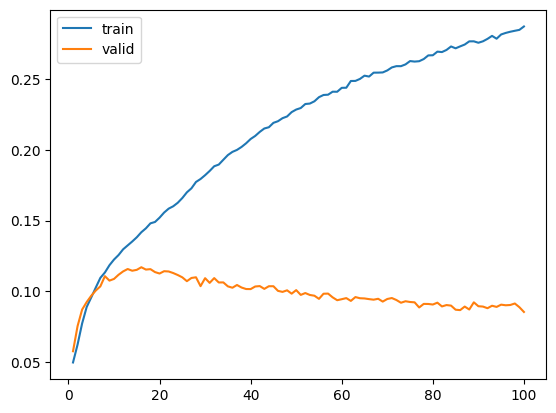

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

In [35]:
import gradio as gr
from torch_helpers import pad_sequences

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Transformo a tensor
    tensor = torch.from_numpy(encoded.astype(np.int32)).to(device)

    # Predicción softmax
    y_hat = model1(tensor).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break
    
    print('Entrada: ', human_text)

    print('Salida:  ', human_text + ' ' + out_word)

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

C:\Users\PC-01\AppData\Local\Temp\ipykernel_16988\1459320502.py:32: UserWarning: `layout` parameter is deprecated, and it has no effect
  iface = gr.Interface(


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Entrada:  the flight is
Salida:   the flight is besides
Entrada:  the services have
Salida:   the services have bad
Entrada:  food was
Salida:   food was decent
Entrada:  was walking
Salida:   was walking found
Entrada:  the food seems
Salida:   the food seems and
Entrada:  the food
Salida:   the food a
Entrada:  cleaning staff
Salida:   cleaning staff went
Entrada:  cleaning staff was
Salida:   cleaning staff was serving
Keyboard interruption in main thread... closing server.


Conclusiones

-  Se utilizo un dataset de review sobre los servisioc de una empresa (tripadvisor) eligiendo 1000 reviews con valoracion de 1 putno.

- Un tamaño de embbeding menor a 15 el modelo no aprende debido a la variabilidad de las palabras. Con 20 se obtuvo mejores resultados.